In [6]:
# Define the gpu on the gpu machine
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [20]:
# Check which gpus can now be seen from your code
cuda.detect()

Found 1 CUDA devices
id 0       b'A100-PCIE-40GB'                              [SUPPORTED]
                      Compute Capability: 8.0
                           PCI Device ID: 0
                              PCI Bus ID: 38
                                    UUID: GPU-46fb3d63-b174-7084-e3e4-c36b1fee00b1
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 2
Summary:
	1/1 devices are supported


True

In [21]:
import pandas as pd
import numpy as np
import json
from simpletransformers.ner import NERModel, NERArgs
from tqdm.autonotebook import tqdm as notebook_tqdm
import wandb
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import logging
import sklearn
from numba import cuda

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [8]:
# Login to wandb
wandb.login()

True

In [9]:
# Import the dataset

# Define the path to the dataset
dataset_path = "datasets/hr500k.conllup_extracted.json"

# Load the json file
with open(dataset_path, "r") as file:
    json_dict = json.load(file)

# Open the train, eval and test dictionaries as DataFrames
train_df = pd.DataFrame(json_dict["train"])
test_df = pd.DataFrame(json_dict["test"])
dev_df = pd.DataFrame(json_dict["dev"])

# Define the labels
LABELS = json_dict["labels"]
print(LABELS)

print(train_df.shape, test_df.shape, dev_df.shape)
print(train_df.head())

['*', 'B-loc', 'B-org', 'B-per', 'I-per', 'B-deriv-per', 'I-org', 'I-loc', 'B-misc', 'I-misc', 'I-deriv-per']
(398681, 3) (51190, 3) (49764, 3)
    sentence_id      words labels
717  set.hr-s36      Kazna      *
718  set.hr-s36  medijskom      *
719  set.hr-s36     mogulu      *
720  set.hr-s36   obnovila      *
721  set.hr-s36   raspravu      *


In [22]:
# Change * to O
if "*" in LABELS:
    LABELS[LABELS.index("*")] = "O"

    for df in [train_df, test_df, dev_df]:
        df["labels"] = np.where(df["labels"] == "*", "O", df["labels"])

print(LABELS)
print(test_df.head())

['O', 'B-loc', 'B-org', 'B-per', 'I-per', 'B-deriv-per', 'I-org', 'I-loc', 'B-misc', 'I-misc', 'I-deriv-per']
      sentence_id     words labels
6004  set.hr-s297   Beograd  B-loc
6005  set.hr-s297         i      O
6006  set.hr-s297  Priština  B-loc
6007  set.hr-s297  postigli      O
6008  set.hr-s297   dogovor      O


In [11]:
# Define the model

# Model type - a dictionary of type and model name.
# To refer to our own models, use the path to the model directory as the model name.
model_type_dict = {
    "sloberta": ["camembert", "EMBEDDIA/sloberta"],
    "csebert": ["bert", "EMBEDDIA/crosloengual-bert"],
    "xlm-r-base": ["xlmroberta", "xlm-roberta-base"],
    "xlm-r-large": ["xlmroberta", "xlm-roberta-large"],
    "bertic": ["electra", "classla/bcms-bertic"]
}

In [12]:
# Try to run the model to see if everything works
batch_size = 32
epochs = 1

model_args = NERArgs()

# define hyperparameters
model_args ={"overwrite_output_dir": True,
             "num_train_epochs": epochs,
             "labels_list": LABELS,
             "learning_rate": 1e-5,
             "train_batch_size": batch_size,
             # Comment out no_cache and no_save if you want to save the model
             "no_cache": True,
             "no_save": True,
            # Only the trained model will be saved (if you want to save it)
            # - to prevent filling all of the space
            # "save_model_every_epoch":False,
             "max_seq_length": 256,
             "save_steps": -1,
            # Use these parameters if you want to evaluate during training
            #"evaluate_during_training": True,
            ## Calculate how many steps will each epoch have
            # num steps in epoch = training samples / batch size
            # Then evaluate after every 3rd epoch
            #"evaluate_during_training_steps": len(train_df.words)/batch_size*3,
            #"evaluate_during_training_verbose": True,
            #"use_cached_eval_features": True,
            #'reprocess_input_data': True,
            #"wandb_project": "NER",
            "silent": True,
            #"wandb_kwargs": {"name": "default"},
             }


In [23]:
# Choose the model
current_model_name = "xlm-r-large"

current_model = NERModel(
    model_type_dict[current_model_name][0],
    model_type_dict[current_model_name][1],
    use_cuda=True,
    args = model_args)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Train the model
current_model.train_model(train_df)

INFO:simpletransformers.ner.ner_model: Converting to features started.
/home/tajak/NER-recognition/ner/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
INFO:simpletransformers.ner.ner_model: Training of xlmroberta model complete. Saved to outputs/.


(619, 0.15293829199317874)

In [25]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [96]:
# Evaluating the model
results =  current_model.eval_model(test_df)

INFO:simpletransformers.ner.ner_model: Converting to features started.
INFO:simpletransformers.ner.ner_model:{'eval_loss': 0.04616385788423379, 'precision': 0.8540660972892685, 'recall': 0.8876881512929371, 'f1_score': 0.870552611657835}


In [98]:
preds = results[1]

preds_list = []

for sentence in preds:
    for word in sentence:
        current_word = []
        for element in word:
            # Find prediction with the highest value
            highest_index = element.index(max(element))
            # Transform the index to label
            current_pred = current_model.config.id2label[highest_index]
            # Append to the list
            current_word.append(current_pred)
        # Segmentation can result in multiple predictions for one word - use the first prediction only
        preds_list.append(current_word[0])

# Append the preds_list to test df
test_df["preds"] = preds_list



Macro f1: 0.0974, Micro f1: 0.84
Accuracy: 0.84


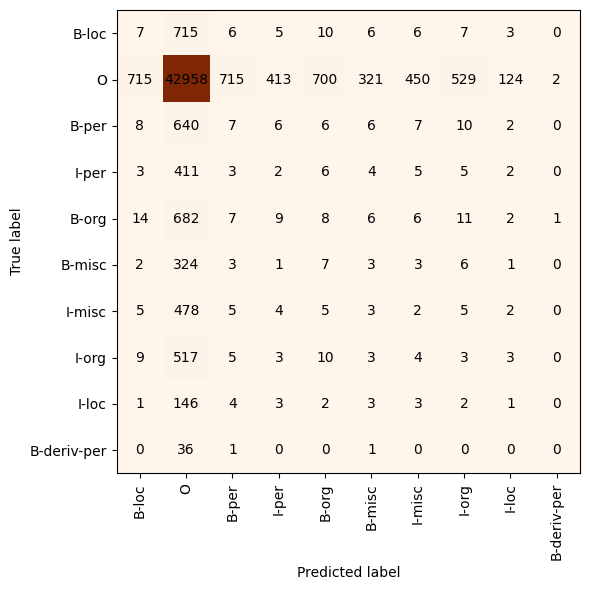

              precision    recall  f1-score   support

       B-loc       0.00      0.00      0.00        38
           O       0.01      0.01      0.01       765
       B-per       0.01      0.01      0.01       350
       I-per       0.01      0.01      0.01       746
       B-org       0.01      0.01      0.01       692
      B-misc       0.01      0.01      0.01       165
      I-misc       0.00      0.00      0.00       509
       I-org       0.01      0.01      0.01       557
       I-loc       0.00      0.00      0.00       441
 B-deriv-per       0.92      0.92      0.92     46927

    accuracy                           0.84     51190
   macro avg       0.10      0.10      0.10     51190
weighted avg       0.84      0.84      0.84     51190



{'accuracy': 0.8398319984371948,
 'micro F1': 0.8398319984371948,
 'macro F1': 0.09739804144201585}

<Figure size 640x480 with 0 Axes>

In [103]:
# Evaluate predictions
import evaluate

evaluate.testing(list(test_df.labels), list(test_df.preds),list(test_df.labels.unique()), show_matrix=True)



# Hyperparameter Optimization - Run the W&B sweep

We can set up the default configuration for the Simple Transformers model. This would include any args that are not being optimized through the sweep.

Hint: As a rule of thumb, it might be a good idea to set all of reprocess_input_data, overwrite_output_dir, and no_save to True when running sweeps.

In [ ]:
# Set up the sweep

# Define the sweep config
sweep_config = {
    'method': 'random',
    # Command the sweep to terminate
    #'early_terminate': {
    #   "type": "hyperband",
    #    "max_iter": 20,
    #    "s": 2}
    }

# Define the metric. If it is accuracy, you want to maximize it.
# If it is loss, you want to minimize it.

metric = {
    'name': 'train_loss',
    'goal': 'minimize'
    }

# Specify the hyperparameters

parameters_dict = {
    "num_train_epochs":{
        # a flat distribution between 0 and 0.1
        'distribution': 'int_uniform',
        'min': 3,
        'max': 10,
        #'values': [3, 5, 10]
    },
    "learning_rate": {
        'min': 5e-5,
        'max': 4e-4
        #'values': [1e-5, 4e-5, 1e-6]
    }

}

sweep_config['metric'] = metric
sweep_config['parameters'] = parameters_dict

# Define sweep_id
sweep_id = wandb.sweep(sweep_config, project="NER")

The first thing we need to define is the `method`
for choosing new parameter values.

We provide the following search `methods`:
*   **`grid` Search** – Iterate over every combination of hyperparameter values.
Very effective, but can be computationally costly.
*   **`random` Search** – Select each new combination at random according to provided `distribution`s. Surprisingly effective!
*   **`bayes`ian Search** – Create a probabilistic model of metric score as a function of the hyperparameters, and choose parameters with high probability of improving the metric. Works well for small numbers of continuous parameters but scales poorly.

For a `grid` search, you need to specify values.

For a `random` search, all the `values` of a parameter are equally likely to be chosen on a given run. You can also specify a named `distribution`,
plus its parameters, like the mean `mu` and standard deviation `sigma` of a `normal` distribution.

We'll stick with `random`.

In [ ]:
# Define model's arguments
model_args = NERArgs()
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.evaluate_during_training = True
model_args.manual_seed = 4
model_args.use_multiprocessing = True
model_args.train_batch_size = 32
model_args.eval_batch_size = 32
model_args.labels_list = LABELS
model_args.no_cache = True
model_args.no_save = True
model_args.max_seq_length = 512
model_args.save_steps = -1
## Calculate how many steps will each epoch have
# num steps in epoch = training samples / batch size
# Then evaluate after every 3rd epoch
#model_args.evaluate_during_training_steps = len(train_df.words)/32*3
model_args.evaluate_during_training_verbose = True
model_args.wandb_project = "NER"

### Set up the training function
W&B will call this function to run the training for a particular sweep run. This function must perform 3 critical tasks.

Initialize the wandb run
Initialize a Simple Transformers model and pass in sweep_config=wandb.config as a kwarg.
Run the training for the Simple Transformers model.
wandb.config contains the hyperparameter values for the current sweeps run. Simple Transformers will update the model args accordingly.

In [ ]:
def train(model_name, train_df, dev_df):
    # Initialize a new wandb run
    wandb.init()

    model_type_dict = {
        "sloberta": ["camembert", "EMBEDDIA/sloberta"],
        "csebert": ["bert", "EMBEDDIA/crosloengual-bert"],
        "xlm-r-base": ["xlmroberta", "xlm-roberta-base"],
        "xlm-r-large": ["xlmroberta", "xlm-roberta-large"],
        "bertic": ["electra", "classla/bcms-bertic"]
    }

    # Create a model
    model = NERModel(
        model_type_dict[model_name][0],
        model_type_dict[model_name][1],
        use_cuda=True,
        args = model_args,
        sweep_config=wandb.config,)

    # Train the model
    model.train_model(train_df, eval_df=dev_df)

    # Evaluate the model
    model.eval_model(dev_df)

    # Sync wandb
    wandb.join()

In [ ]:
# Choose the model - insert the model name as it is in the model_type_dict
model_name = "xlm-r-base"

# Run the sweep
wandb.agent(sweep_id, train(model_name, train_df, dev_df))

## Use Model

In [ ]:
# Define the model

# Model type - a dictionary of type and model name.
# To refer to our own models, use the path to the model directory as the model name.
model_type_dict = {
    "sloberta": ["camembert", "EMBEDDIA/sloberta"],
    "csebert": ["bert", "EMBEDDIA/crosloengual-bert"],
    "xlm-r-base": ["xlmroberta", "xlm-roberta-base"],
    "xlm-r-large": ["xlmroberta", "xlm-roberta-large"],
    "bertic": ["electra", "classla/bcms-bertic"]
}

batch_size = 32
epochs = 10

model_args = NERArgs()

# define hyperparameters
model_args ={"overwrite_output_dir": True,
             "num_train_epochs": epochs,
             "labels_list": LABELS,
             "learning_rate": 1e-5,
             "train_batch_size": batch_size,
             # Comment out no_cache and no_save if you want to save the model
             "no_cache": True,
             "no_save": True,
            # Only the trained model will be saved (if you want to save it)
            # - to prevent filling all of the space
            # "save_model_every_epoch":False,
             "max_seq_length": 512,
             "save_steps": -1,
            # Use these parameters if you want to evaluate during training
            "evaluate_during_training": True,
            ## Calculate how many steps will each epoch have
            # num steps in epoch = training samples / batch size
            # Then evaluate after every 3rd epoch
            "evaluate_during_training_steps": len(train_df.words)/batch_size*3,
            "evaluate_during_training_verbose": True,
            "use_cached_eval_features": True,
            'reprocess_input_data': True,
            "wandb_project": "NER",
            "silent": True,
            "wandb_kwargs": {"name": "default"},
             }


In [ ]:
# Initialize Wandb
wandb.init(project="NER", entity="tajak", name="initialization", config = model_args)
# Save all hyperparameters in wandb config so that they are logged
wandb.config = model_args

In [ ]:
# Choose the model
current_model_name = "xlm-r-base"

current_model = NERModel(
    model_type_dict[current_model_name][0],
    model_type_dict[current_model_name][1],
    use_cuda=True,
    args = model_args)

In [ ]:
# Train the model

current_model.train_model(train_df, eval_data=dev_df)

In [ ]:
# Evaluating the model
result, model_outputs, wrong_preds = current_model.eval_model(test_df)

# To use the model for prediction
# predictions, raw_outputs = model.predict(["Sample sentence 1", "Sample sentence 2"])
# Prediction on already segmented words:
# predictions, raw_outputs = model.predict([["Ron", "is", "Harry's", "best", "friend"], ["Hrmione", "was", "the ", "best", "in", "her", "class"]], split_on_space=False)

In [ ]:
# Clean the GPU cache
cuda.select_device(0)
cuda.close()
cuda.select_device(0)
torch.cuda.empty_cache()